In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import timedelta

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
import io
df = pd.read_csv("/content/sample_data/covid_19_data.csv")
# df = pd.read_csv(io.BytesIO(uploaded['covid_19_data.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
df.isnull().sum()

SNo                    0
ObservationDate        0
Province/State     78100
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [ ]:
df.drop(["SNo"],1,inplace=True)

In [ ]:
df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
#Converting "Observation Date" into Datetime format
df["ObservationDate"]=pd.to_datetime(df["ObservationDate"])

In [ ]:
df.head(5)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
#Country wise Visualisation of COVID-19. 
groupby_country=df[df["ObservationDate"]==df["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
groupby_country

,Confirmed,Recovered,Deaths
Country/Region,,,
US,33251939.0,0.0,594306.0
India,27894800.0,25454320.0,325972.0
Brazil,16471600.0,14496224.0,461057.0
France,5719877.0,390878.0,109518.0
Turkey,5235978.0,5094279.0,47271.0
...,...,...,...
Vanuatu,4.0,3.0,1.0
Marshall Islands,4.0,4.0,0.0
Samoa,3.0,3.0,0.0


In [ ]:
grouped_country=df.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])
grouped_country.head()

Confirmed  ...  log_active
Country/Region  ObservationDate             ...            
 Azerbaijan     2020-02-28             1.0  ...    0.000000
('St. Martin',) 2020-03-10             2.0  ...    0.693147
Afghanistan     2020-02-24             1.0  ...    0.000000
                2020-02-25             1.0  ...    0.000000
                2020-02-26             1.0  ...    0.000000

[5 rows x 6 columns]

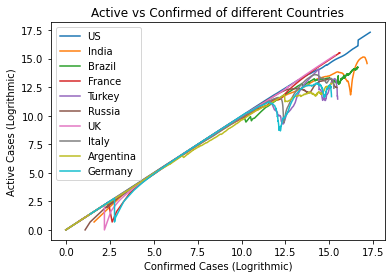

In [ ]:
for i in groupby_country.head(10).index:
  plt.plot(grouped_country.loc[i]["log_confirmed"], grouped_country.loc[i]["log_active"],label= i)
plt.xlabel('Confirmed Cases (Logrithmic)')
plt.ylabel('Active Cases (Logrithmic)')
plt.legend()
plt.title('Active vs Confirmed of different Countries')
plt.show()

In [ ]:
#Grouping different types of cases as per the date
groupby_date=df.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
# datewise["Days Since"]=datewise.index-datewise.index.min()
groupby_date["Days Since"]=groupby_date.index-groupby_date.index.min()

In [ ]:
# groupby_date.head()

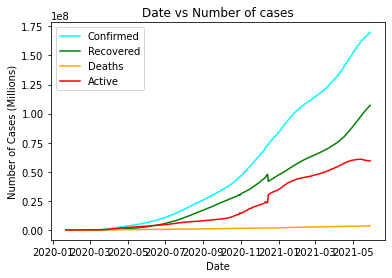

In [ ]:
plt.plot(groupby_date.index,groupby_date["Confirmed"],color = 'cyan')
plt.plot(groupby_date.index,groupby_date["Recovered"],color = 'green')
plt.plot(groupby_date.index,groupby_date["Deaths"],color = 'orange')
plt.plot(groupby_date.index,groupby_date["Confirmed"]-groupby_date["Recovered"]-groupby_date["Deaths"],color = 'red')
plt.xlabel('Date')
plt.ylabel('Number of Cases (Millions)')
plt.legend(['Confirmed','Recovered','Deaths','Active'])
plt.title('Date vs Number of cases')
plt.show()

In [ ]:
#Time Series Prediction 
rmse_scores =[]

In [ ]:
model_training=groupby_date.iloc[:int(groupby_date.shape[0]*0.95)]
test=groupby_date.iloc[int(groupby_date.shape[0]*0.95):]
y_pred=test.copy()

In [ ]:
#ARIMA Model using auto_arima
arima_model_c= auto_arima(model_training["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
arima_model_c.fit(model_training["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11809.478, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11785.886, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=11738.463, Time=0.12 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=11730.267, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11798.602, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11730.635, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=11753.103, Time=0.22 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=11835.814, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11798.849, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11716.037, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=11543.789, Time=0.95 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11750.641, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11650.242, Time=0.27 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=11534.633, Time=0.90 sec



ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
arima_pred_c=arima_model_c.predict(len(test))
y_pred["ARIMA Model Prediction"]=arima_pred_c

In [ ]:
rmse_scores.append(np.sqrt(mean_squared_error(test["Confirmed"],arima_pred_c)))
print("RMSE for ARIMA Model: ",np.sqrt(mean_squared_error(test["Confirmed"],arima_pred_c)))

RMSE for ARIMA Model:  3160138.061025051


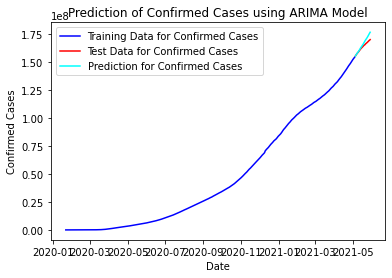

In [ ]:
plt.plot(model_training.index,model_training["Confirmed"],color = 'blue')
plt.plot(test.index,test["Confirmed"],color = 'red')
plt.plot(test.index,y_pred["ARIMA Model Prediction"],color = 'cyan')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(['Training Data for Confirmed Cases','Test Data for Confirmed Cases','Prediction for Confirmed Cases'])
plt.title('Prediction of Confirmed Cases using ARIMA Model')
plt.show()

In [ ]:
ARIMA_Confirmed_prediction=[]
dates=[]
for i in range(1,18):
    dates.append(groupby_date.index[-1]+timedelta(days=i))
    ARIMA_Confirmed_prediction.append(arima_model_c.predict(len(test)+i)[-1])
predicted_models = pd.DataFrame(dates,columns=['Dates'])    
predicted_models["ARIMA Model Prediction"]=ARIMA_Confirmed_prediction
predicted_models.head()

,Dates,ARIMA Model Prediction
0,2021-05-30,1.774161e+08
1,2021-05-31,1.782993e+08
2,2021-06-01,1.792630e+08
3,2021-06-02,1.803118e+08
4,2021-06-03,1.813912e+08


In [ ]:
#Prediction of Confirmed Cases using Facebooks Prophet Model
prophet_model_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed_df=pd.DataFrame(zip(list(groupby_date.index),list(groupby_date["Confirmed"])),columns=['ds','y'])
prophet_confirmed_df.head()

,ds,y
0,2020-01-22,557.0
1,2020-01-23,1097.0
2,2020-01-24,941.0
3,2020-01-25,1437.0
4,2020-01-26,2118.0


In [ ]:
prophet_model_c.fit(prophet_confirmed_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecasting_c=prophet_model_c.make_future_dataframe(periods=17)
forecasting_confirmed=forecasting_c.copy()

In [ ]:
confirmed_forecast=prophet_model_c.predict(forecasting_c)
print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2020-01-22 -1.279650e+05 -2.049320e+06  1.911520e+06
1   2020-01-23 -7.293718e+04 -2.126449e+06  1.937128e+06
2   2020-01-24 -2.795659e+04 -2.120814e+06  1.905926e+06
3   2020-01-25 -2.723673e+04 -2.149090e+06  1.903299e+06
4   2020-01-26 -8.550744e+04 -2.112425e+06  1.935867e+06
..         ...           ...           ...           ...
506 2021-06-11  1.770610e+08  1.749611e+08  1.792968e+08
507 2021-06-12  1.776808e+08  1.753403e+08  1.800471e+08
508 2021-06-13  1.782416e+08  1.760506e+08  1.805660e+08
509 2021-06-14  1.788133e+08  1.763971e+08  1.814137e+08
510 2021-06-15  1.794377e+08  1.770359e+08  1.818293e+08

[511 rows x 4 columns]


In [ ]:
rmse_scores.append(np.sqrt(mean_squared_error(groupby_date["Confirmed"],confirmed_forecast['yhat'].head(groupby_date.shape[0]))))
print("RMSE for Prophet Model: ",np.sqrt(mean_squared_error(groupby_date["Confirmed"],confirmed_forecast['yhat'].head(groupby_date.shape[0]))))

RMSE for Prophet Model:  1025041.3391496495


Figure(720x432)


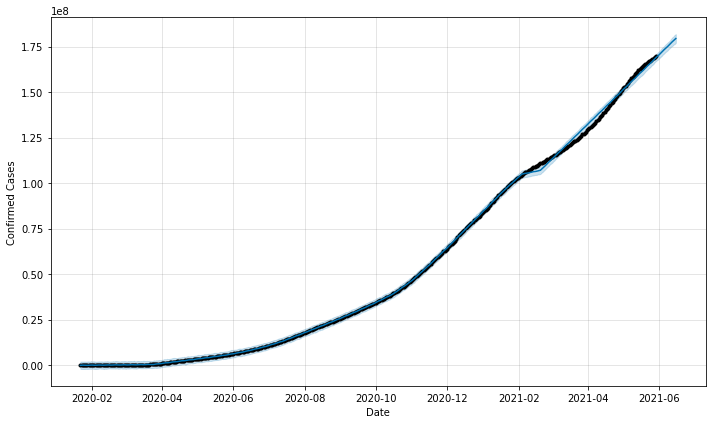

In [ ]:
print(prophet_model_c.plot(confirmed_forecast, xlabel='Date', ylabel='Confirmed Cases' ))

Figure(648x432)


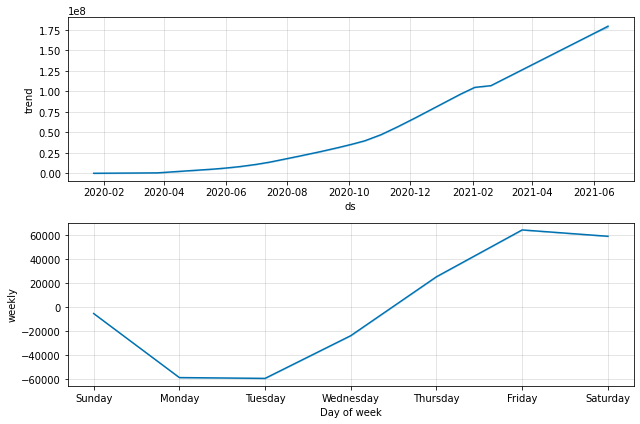

In [ ]:
print(prophet_model_c.plot_components(confirmed_forecast))

In [ ]:
model_names=["ARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,rmse_scores),columns=["Model Name","RMSE"]).sort_values(["RMSE"])
model_summary

,Model Name,RMSE
1,Facebook's Prophet Model,1.025041e+06
0,ARIMA Model,3.160138e+06


In [ ]:
model_training=groupby_date.iloc[:int(groupby_date.shape[0]*0.95)]
test=groupby_date.iloc[int(groupby_date.shape[0]*0.95):]
y_pred=test.copy()

In [ ]:
#ARIMA Model using auto_arima
arima_model_c= auto_arima(model_training["Deaths"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
arima_model_c.fit(model_training["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=8372.566, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8373.587, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=8257.762, Time=0.36 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=8225.545, Time=0.89 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=8374.053, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8283.551, Time=0.81 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8246.770, Time=0.92 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=8206.469, Time=1.16 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8343.019, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8201.054, Time=0.78 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=8079.128, Time=1.08 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=8032.472, Time=1.26 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8298.821, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=8164.503, Time=0.97 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=8206.161, Time=1.28 sec

Best mode

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [ ]:
arima_pred_c=arima_model_c.predict(len(test))
y_pred["ARIMA Deaths Prediction"]=arima_pred_c

In [ ]:
rmse_scores.append(np.sqrt(mean_squared_error(test["Deaths"],arima_pred_c)))
print("RMSE for ARIMA Model: ",np.sqrt(mean_squared_error(test["Deaths"],arima_pred_c)))

RMSE for ARIMA Model:  21815.720598717322


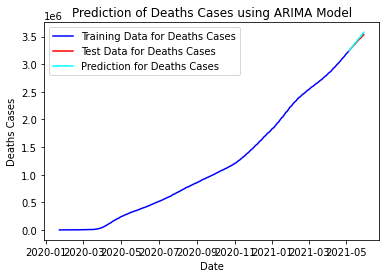

In [ ]:
plt.plot(model_training.index,model_training["Deaths"],color = 'blue')
plt.plot(test.index,test["Deaths"],color = 'red')
plt.plot(test.index,y_pred["ARIMA Deaths Prediction"],color = 'cyan')
plt.xlabel('Date')
plt.ylabel('Deaths Cases')
plt.legend(['Training Data for Deaths Cases','Test Data for Deaths Cases','Prediction for Deaths Cases'])
plt.title('Prediction of Deaths Cases using ARIMA Model')
plt.show()

In [ ]:
ARIMA_Death_prediction=[]
for i in range(1,18):
    ARIMA_Death_prediction.append(arima_model_c.predict(len(test)+i)[-1])

In [ ]:
pd.DataFrame(zip(dates,ARIMA_Death_prediction),columns=['Deaths','ARIMA_Death_prediction']) 

,Deaths,ARIMA_Death_prediction
0,2021-05-30,3.590316e+06
1,2021-05-31,3.602595e+06
2,2021-06-01,3.616802e+06
3,2021-06-02,3.633077e+06
4,2021-06-03,3.650049e+06
5,2021-06-04,3.665852e+06
6,2021-06-05,3.679522e+06
7,2021-06-06,3.691710e+06
8,2021-06-07,3.704200e+06
9,2021-06-08,3.718577e+06
